#### Adicionando o caminho do projeto ao path

In [1]:
import os
os.chdir('/Users/edithvidal/Documents/Github/data_science_analysis/')

#### Instalando sklearn

In [2]:
%pip install scikit-learn


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install category_encoders



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install imbalanced-learn



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


#### Importando as bibliotecas necessárias

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


#### Lendo dados da base após análise

In [6]:
df_accidents = pd.read_csv(
    "analysis/datatran2018_2024_v3.csv",
    parse_dates=["mes_ano"]
)
df_accidents.info()
df_accidents.reset_index(drop=True, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467078 entries, 0 to 467077
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   tipo_data               429733 non-null  object        
 1   mes_ano                 467078 non-null  datetime64[ns]
 2   dia_semana              429733 non-null  object        
 3   fase_dia                429733 non-null  object        
 4   condicao_metereologica  429733 non-null  object        
 5   uf                      429733 non-null  object        
 6   br                      429733 non-null  float64       
 7   uso_solo                429733 non-null  object        
 8   tipo_pista              429733 non-null  object        
 9   sentido_via             429733 non-null  object        
 10  tipo_acidente           429733 non-null  object        
 11  causa_acidente          429733 non-null  object        
 12  classificacao_acidente  429733

/var/folders/z1/3syxl8gd5ks431s8c9n9mrs00000gn/T/ipykernel_35034/2452157731.py:1: DtypeWarning: Columns (0,2,3,4,5,7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_accidents = pd.read_csv(


#### Removendo colunas que não serão utilizadas para a classificação

In [7]:
df = df_accidents.copy()
df.drop(columns=[
    "mes_ano",
    "tipo_data",
    "classificacao_acidente",
    "pessoas",
    "veiculos"
], inplace=True)

df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 429733 entries, 0 to 429732
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   dia_semana              429733 non-null  object 
 1   fase_dia                429733 non-null  object 
 2   condicao_metereologica  429733 non-null  object 
 3   uf                      429733 non-null  object 
 4   br                      429733 non-null  float64
 5   uso_solo                429733 non-null  object 
 6   tipo_pista              429733 non-null  object 
 7   sentido_via             429733 non-null  object 
 8   tipo_acidente           429733 non-null  object 
 9   causa_acidente          429733 non-null  object 
dtypes: float64(1), object(9)
memory usage: 36.1+ MB


#### Agrupando tipos de acidente para facilitar a classificação

In [8]:
df["tipo_acidente"].value_counts()

tipo_acidente
Colisão traseira                   81314
Saída de leito carroçável          67518
Colisão transversal                54276
Tombamento                         35660
Colisão frontal                    28970
Colisão lateral                    24476
Colisão lateral mesmo sentido      23272
Atropelamento de pedestre          19884
Queda de ocupante de veículo       19182
Colisão com objeto                 16729
Colisão com objeto estático        14144
Capotamento                        12119
Incêndio                            8092
Atropelamento de animal             7337
Engavetamento                       6732
Colisão lateral sentido oposto      6444
Derramamento de carga               1032
Eventos atípicos                    1012
Colisão com objeto em movimento      941
Danos eventuais                      599
Name: count, dtype: int64

In [9]:
accidents = {
    "Colisão traseira": "Colisão",
    "Colisão transversal": "Colisão",
    "Colisão frontal": "Colisão",
    "Colisão lateral": "Colisão",
    "Colisão lateral mesmo sentido": "Colisão",
    "Colisão lateral sentido oposto": "Colisão",
    "Colisão com objeto": "Colisão",
    "Colisão com objeto estático": "Colisão",
    "Colisão com objeto em movimento": "Colisão",
    "Atropelamento de animal": "Atropelamento",
    "Atropelamento de pedestre": "Atropelamento",
    "Capotamento": "Perda de controle",
    "Tombamento": "Perda de controle",
    "Saída de leito carroçável": "Perda de controle",
    "Engavetamento": "Perda de controle",
    "Derramamento de carga": "Evento externo",
    "Incêndio": "Evento externo",
    "Eventos atípicos": "Evento externo",
    "Danos eventuais": "Evento externo",
    "Queda de ocupante de veículo": "Queda de ocupante de veículo"
}

df["tipo_acidente"] = df["tipo_acidente"].map(accidents)
df["tipo_acidente"].value_counts()

tipo_acidente
Colisão                         250566
Perda de controle               122029
Atropelamento                    27221
Queda de ocupante de veículo     19182
Evento externo                   10735
Name: count, dtype: int64

#### OneHotEncoder + RandomForestClassifier

In [11]:
target_col = 'tipo_acidente'

# 1. Features categóricas que você quer usar
categorical_features = [
    'dia_semana', 'fase_dia', 'condicao_metereologica',
    'uf', 'uso_solo', 'tipo_pista', 'sentido_via', 'causa_acidente'
]

# 2. Separar X e y
X = df[categorical_features]
y = df[target_col]

# 3. Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 4. Preprocessamento (OneHotEncoder para dados categóricos)
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# 5. Montar o pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        class_weight='balanced',  # trata desbalanceamento
        random_state=42,
        n_estimators=30,
        max_depth=10,
        n_jobs=-1  # usa todos os núcleos disponíveis
    ))
])

# 6. Treinar o modelo
pipeline.fit(X_train, y_train)

# 7. Avaliar
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))


                              precision    recall  f1-score   support

               Atropelamento       0.85      0.74      0.79      8166
                     Colisão       0.84      0.55      0.67     75170
              Evento externo       0.36      0.80      0.49      3220
           Perda de controle       0.47      0.65      0.54     36609
Queda de ocupante de veículo       0.11      0.26      0.15      5755

                    accuracy                           0.58    128920
                   macro avg       0.52      0.60      0.53    128920
                weighted avg       0.69      0.58      0.61    128920



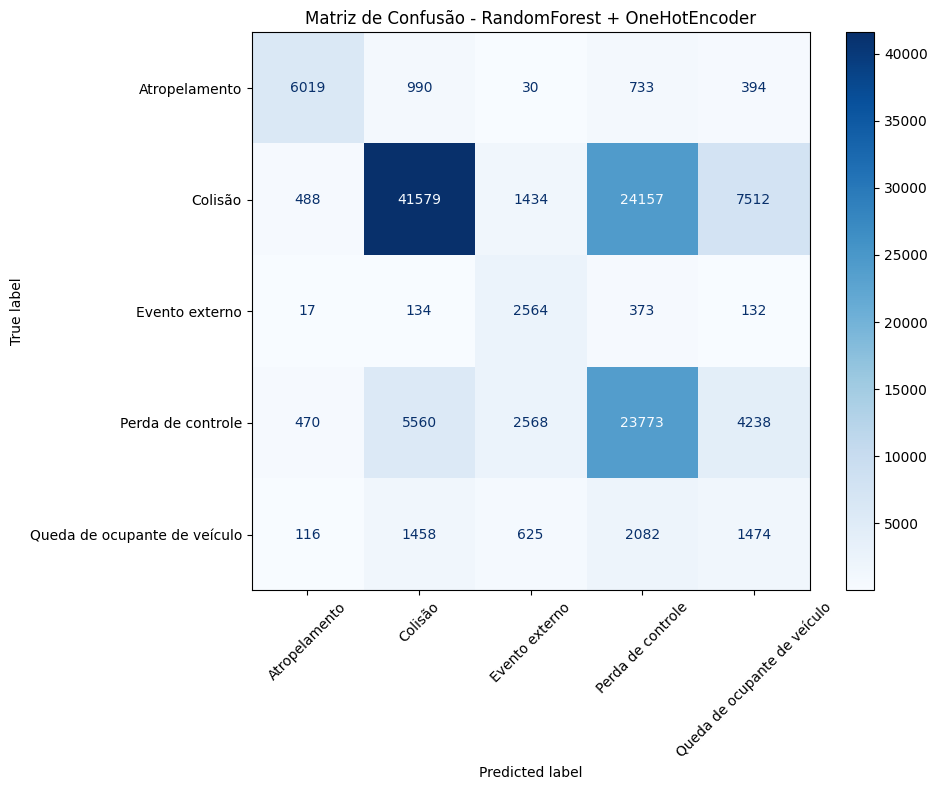

In [12]:
# Gerar matriz de confusão
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)

# Visualizar
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title('Matriz de Confusão - RandomForest + OneHotEncoder')
plt.tight_layout()
plt.show()

#### TargetEncoder + RandomForestClassifier

In [13]:
# Variáveis
target_col = 'tipo_acidente'
categorical_features = [
    'dia_semana', 'fase_dia', 'condicao_metereologica',
    'uf', 'uso_solo', 'tipo_pista', 'sentido_via', 'causa_acidente'
]

# Separar dados
X = df[categorical_features]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Pipeline com TargetEncoder + RandomForest
pipeline = Pipeline([
    ('encoder', TargetEncoder(cols=categorical_features)),
    ('classifier', RandomForestClassifier(
        class_weight='balanced',
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ))
])

# Treinar
pipeline.fit(X_train, y_train)

# Previsões
y_pred = pipeline.predict(X_test)

# Relatório textual
print(classification_report(y_test, y_pred))


                              precision    recall  f1-score   support

               Atropelamento       0.65      0.72      0.69      8166
                     Colisão       0.75      0.68      0.71     75170
              Evento externo       0.33      0.46      0.38      3220
           Perda de controle       0.50      0.51      0.50     36609
Queda de ocupante de veículo       0.08      0.14      0.10      5755

                    accuracy                           0.60    128920
                   macro avg       0.46      0.50      0.48    128920
                weighted avg       0.63      0.60      0.62    128920



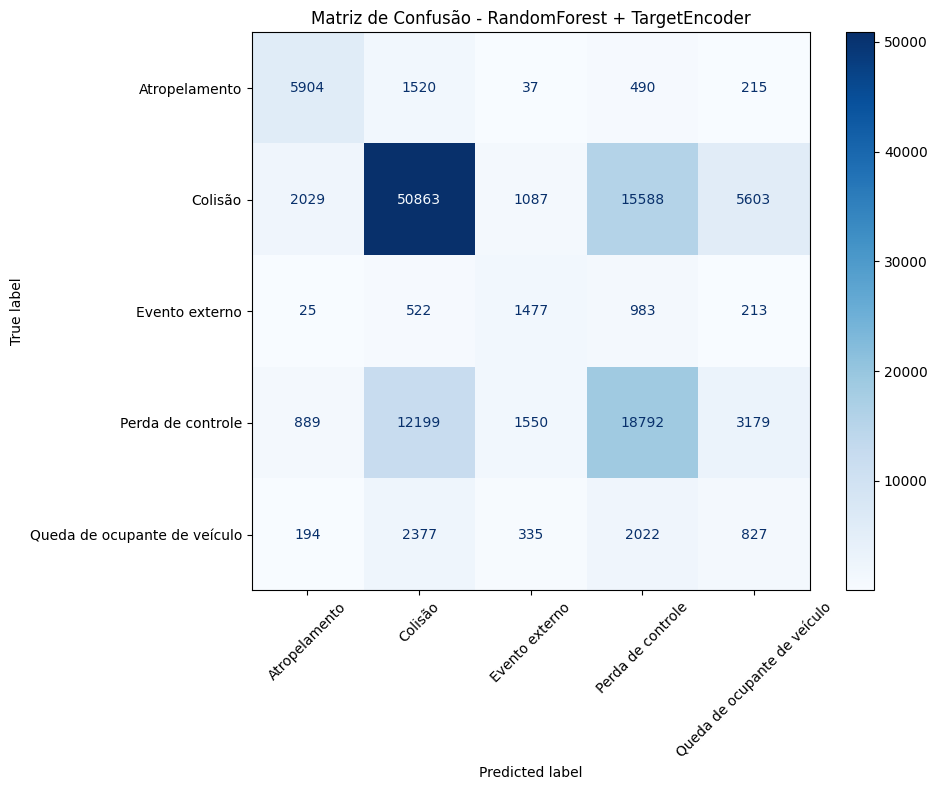

In [14]:
# Gerar matriz de confusão
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)

# Visualizar
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title('Matriz de Confusão - RandomForest + TargetEncoder')
plt.tight_layout()
plt.show()


#### TargetEncoder + DecisionTreeClassifier

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV


# Variáveis
target_col = 'tipo_acidente'
categorical_features = [
    'dia_semana', 'fase_dia', 'condicao_metereologica',
    'uf', 'uso_solo', 'tipo_pista', 'sentido_via', 'causa_acidente'
]

# Separar dados
X = df[categorical_features]
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Pipeline
pipeline = Pipeline([
    ('encoder', TargetEncoder(cols=categorical_features)),
    ('clf', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])

# Grade de hiperparâmetros
param_grid = {
    'clf__max_depth': [None, 5, 10, 15, 20],
    'clf__min_samples_split': [2, 5, 10, 20],
    'clf__min_samples_leaf': [1, 2, 5, 10]
}

# Configura o GridSearch
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,               # número de folds
    scoring='f1_macro',  # métrica para multiclasse balanceada
    n_jobs=-1,
    verbose=1
)

# Executa busca
grid_search.fit(X_train, y_train)

# Melhores parâmetros
print("Melhores parâmetros:", grid_search.best_params_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Melhores parâmetros: {'clf__max_depth': 10, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 2}
                              precision    recall  f1-score   support

               Atropelamento       0.69      0.78      0.73      8166
                     Colisão       0.85      0.59      0.70     75170
              Evento externo       0.33      0.82      0.47      3220
           Perda de controle       0.49      0.63      0.55     36609
Queda de ocupante de veículo       0.13      0.27      0.18      5755

                    accuracy                           0.60    128920
                   macro avg       0.50      0.62      0.53    128920
                weighted avg       0.69      0.60      0.63    128920



In [23]:
# Variáveis
target_col = 'tipo_acidente'
categorical_features = [
    'dia_semana', 'fase_dia', 'condicao_metereologica',
    'uf', 'uso_solo', 'tipo_pista', 'sentido_via', 'causa_acidente'
]

# Separar dados
X = df[categorical_features]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Pipeline com hiperparâmetros ajustados
pipeline = Pipeline([
    ('encoder', TargetEncoder(cols=categorical_features)),
    ('classifier', DecisionTreeClassifier(
        class_weight='balanced',
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=5,
        random_state=42
    ))
])

# Treinar modelo
pipeline.fit(X_train, y_train)

# Prever
y_pred = pipeline.predict(X_test)

# Avaliar
print(classification_report(y_test, y_pred))

                              precision    recall  f1-score   support

               Atropelamento       0.71      0.78      0.74      5444
                     Colisão       0.83      0.63      0.72     50114
              Evento externo       0.33      0.82      0.47      2147
           Perda de controle       0.54      0.48      0.51     24406
Queda de ocupante de veículo       0.10      0.40      0.16      3836

                    accuracy                           0.59     85947
                   macro avg       0.50      0.62      0.52     85947
                weighted avg       0.70      0.59      0.63     85947



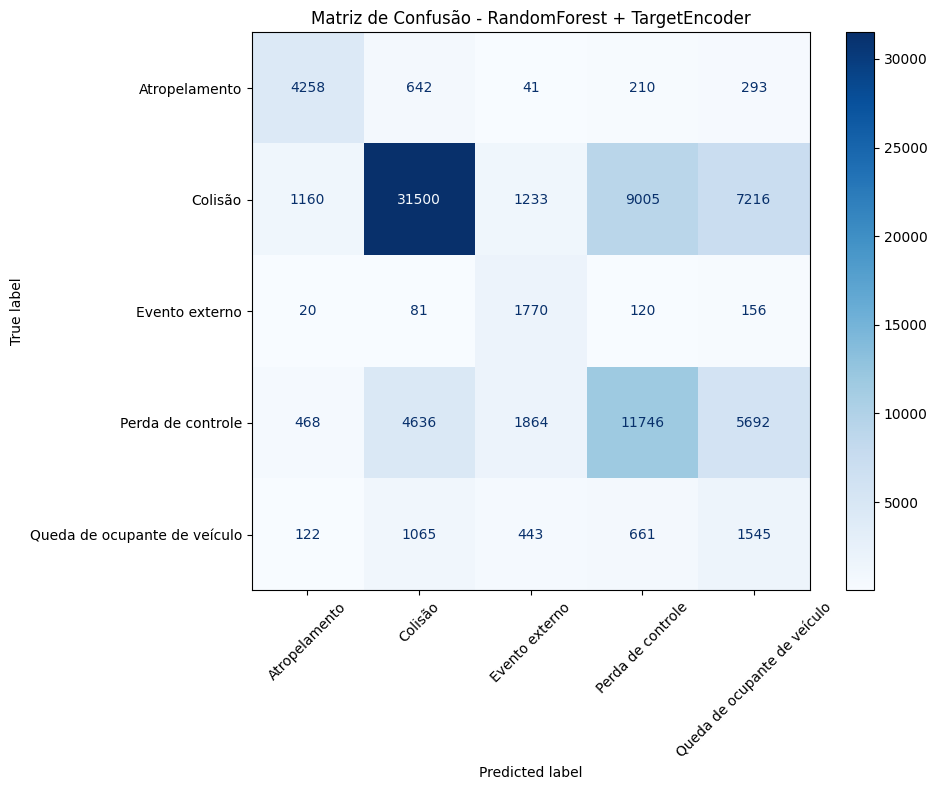

In [24]:
# Gerar matriz de confusão
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)

# Visualizar
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title('Matriz de Confusão - RandomForest + TargetEncoder')
plt.tight_layout()
plt.show()


In [28]:
%pip install graphviz


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [32]:
tree_model = pipeline.named_steps['classifier']
feature_names = categorical_features

def print_tree_rules(tree, feature_names, node=0, depth=0):
    indent = "  " * depth
    if tree.feature[node] != -2:  # não é folha
        name = feature_names[tree.feature[node]]
        threshold = tree.threshold[node]
        print(f"{indent}if {name} <= {threshold:.3f}:")
        print_tree_rules(tree, feature_names, tree.children_left[node], depth + 1)
        print(f"{indent}else:  # {name} > {threshold:.3f}")
        print_tree_rules(tree, feature_names, tree.children_right[node], depth + 1)
    else:
        values = tree.value[node]
        print(f"{indent}return class distribution: {values}")

print_tree_rules(tree_model.tree_, feature_names)


if causa_acidente <= 1.026:
  if causa_acidente <= 0.794:
    if causa_acidente <= 0.360:
      if fase_dia <= 1.608:
        if dia_semana <= 1.673:
          if causa_acidente <= 0.083:
            if dia_semana <= 1.634:
              if uf <= 1.430:
                if tipo_pista <= 1.686:
                  return class distribution: [[1. 0. 0. 0. 0.]]
                else:  # tipo_pista > 1.686
                  return class distribution: [[0.94717769 0.         0.         0.05282231 0.        ]]
              else:  # uf > 1.430
                if uf <= 1.636:
                  if dia_semana <= 1.618:
                    return class distribution: [[0.9857998  0.00198327 0.         0.01221693 0.        ]]
                  else:  # dia_semana > 1.618
                    return class distribution: [[0.99750876 0.00249124 0.         0.         0.        ]]
                else:  # uf > 1.636
                  if uso_solo <= 1.637:
                    return class distribution: [[0.9